<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/pollardstown_cnn_vgg19_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#unzip
!unzip -q "/content/drive/MyDrive/Pollardstown.zip" -d "/content/dataset"

replace /content/dataset/Pollardstown/habitat info.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [19]:
!ls /content/dataset/Pollardstown/

'habitat info.docx'	     Pollardstown_clappied.shx
 Pollardstown_clappied.cpg   pollardstown_ortho.tif
 Pollardstown_clappied.dbf   Pollardstown_Summer_NDVI.tif
 Pollardstown_clappied.prj   Pollardstown_Winter_NDVI.tif
 Pollardstown_clappied.qmd   Pollardstown_Winter_RGB.tif
 Pollardstown_clappied.shp


In [20]:

import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [21]:

rgb_path = "/content/dataset/Pollardstown/pollardstown_ortho.tif"
ndvi_path = "/content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif"

rgb = rasterio.open(rgb_path)
ndvi = rasterio.open(ndvi_path)

In [22]:
shapefile_path = "/content/dataset/Pollardstown/Pollardstown_clappied.shp"
gdf = gpd.read_file(shapefile_path)

# Match CRS
if gdf.crs != rgb.crs:
    gdf = gdf.to_crs(rgb.crs)

try vgg19 with 2 classes

In [23]:
!pip install rasterio geopandas scikit-learn

In [34]:
import os
import numpy as np
import tensorflow as tf
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
from rasterio.features import rasterize
from shapely.geometry import box
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications

paths and params

In [65]:

RGB_PATH   = rgb_path          # GeoTIFF with 3 bands (R,G,B)
NDVI_PATH  = ndvi_path          # GeoTIFF with 1 band (NDVI)
SHP_PATH   = shapefile_path      # Shapefile with habitat polygons
CODE_FIELD = "PRIMARY_FO"


In [26]:

TILE_SIZE  = 224                     # patch size (for VGG19)
STRIDE     = 224                     # stride between patch starts (set 112 for overlap)
MIN_COVER  = 0.70                    # min fraction of dominant class in a patch
BATCH_SIZE = 16


In [52]:

HABITAT_MAP = {
    'PF1': 0, 'WL2': 0, 'WN6': 0, 'WS1': 0, 'WS1/WL2': 0, 'WN6/FS1': 0, 'GS4/WS1': 0,
    'FS1': 1, 'FS1/FS2': 1, 'FS1/PF1': 1, 'GA1': 1, 'GS4': 1, 'GS4/FS1': 1, 'GS4/FS2': 1
}

In [48]:
model = build_vgg19_4channel()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             

 Total params: 45,718,146 (174.40 MB)

 Trainable params: 45,718,146 (174.40 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# --- 2. Windowed Data Generator ---
class HabitatLiveGenerator(tf.keras.utils.Sequence):
    def __init__(self, rgb_path, ndvi_path, gdf, batch_size=8):
        self.rgb_src = rasterio.open(rgb_path)
        self.ndvi_src = rasterio.open(ndvi_path)
        self.gdf = gdf
        self.batch_size = batch_size
        self.indices = np.arange(len(gdf))

    def __len__(self):
        return int(np.floor(len(self.gdf) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []

        for i in batch_indices:
            row = self.gdf.iloc[i]
            geom = [row['geometry']]

            # Mask and crop on the fly
            try:
                rgb_crop, _ = mask(self.rgb_src, geom, crop=True)
                ndvi_crop, _ = mask(self.ndvi_src, geom, crop=True)

                # Stack to (Channels, H, W) -> (4, H, W)
                combined = np.concatenate([rgb_crop, ndvi_crop], axis=0)
                # Reshape to (H, W, 4)
                combined = np.moveaxis(combined, 0, -1)

                # Resize to VGG input 224x224
                # We use simple padding/cropping to stay under 12GB RAM
                final = np.zeros((224, 224, 4), dtype='float32')
                h, w = min(224, combined.shape[0]), min(224, combined.shape[1])
                final[:h, :w, :] = combined[:h, :w, :]

                X.append(final / 255.0) # Normalize
                y.append(HABITAT_MAP[row['PRIMARY_FO']]) # Update column name here
            except:
                continue

        return np.array(X), np.array(y)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [55]:
def build_vgg19_4channel():
    # Input for Red, Green, Blue, and NDVI
    inputs = layers.Input(shape=(224, 224, 4))

    # Load VGG19 without top and without weights (since input is 4 channels)
    base_vgg = applications.VGG19(include_top=False, weights=None, input_tensor=inputs)

    x = layers.GlobalAveragePooling2D()(base_vgg.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x) # 2 Classes

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [66]:
gdf = gpd.read_file('/content/dataset/Pollardstown/Pollardstown_clappied.shp')
# Filter out habitats not in our dictionary
gdf = gdf[gdf['PRIMARY_FO'].isin(HABITAT_MAP.keys())].copy()

# Split into Train/Val
train_gdf = gdf.sample(frac=0.8, random_state=42)
val_gdf = gdf.drop(train_gdf.index)

# Create Generators
train_gen = HabitatLiveGenerator('/content/dataset/Pollardstown/pollardstown_ortho.tif', '/content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif', train_gdf, batch_size=4)
val_gen = HabitatLiveGenerator('/content/dataset/Pollardstown/pollardstown_ortho.tif', '/content/dataset/Pollardstown/Pollardstown_Summer_NDVI.tif', val_gdf, batch_size=4)

# Initialize and Train
model = build_vgg19_4channel()

# 12GB RAM limit: Use small batch size and mixed precision if possible
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

KeyboardInterrupt: 

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import tensorflow as tf
from tensorflow.keras import layers, models, applications

# --- 1. Mapping Configuration ---
# Labels normalized to your two classes
HABITAT_MAP = {
    'PF1': 0, 'WL2': 0, 'WN6': 0, 'WS1': 0, 'WS1/WL2': 0, 'WN6/FS1': 0, 'GS4/WS1': 0, # Wetland
    'FS1': 1, 'FS1/FS2': 1, 'FS1/PF1': 1, 'GA1': 1, 'GS4': 1, 'GS4/FS1': 1, 'GS4/FS2': 1 # Grassland
}

# --- 2. Improved Windowed Data Generator ---
class HabitatLiveGenerator(tf.keras.utils.PyDataset):
    def __init__(self, rgb_path, ndvi_path, gdf, batch_size=4, **kwargs):
        super().__init__(**kwargs) # Fixes the UserWarning
        self.rgb_path = rgb_path
        self.ndvi_path = ndvi_path
        self.gdf = gdf
        self.batch_size = batch_size
        self.indices = np.arange(len(gdf))

    def __len__(self):
        return int(np.floor(len(self.gdf) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []

        # Open files inside getitem to ensure thread-safety during training
        with rasterio.open(self.rgb_path) as rgb_src, rasterio.open(self.ndvi_path) as ndvi_src:
            for i in batch_indices:
                row = self.gdf.iloc[i]
                geom = [row['geometry']]

                try:
                    # Crop RGB and NDVI
                    rgb_crop, _ = mask(rgb_src, geom, crop=True)
                    ndvi_crop, _ = mask(ndvi_src, geom, crop=True)

                    # Stack: (4, H, W) -> (H, W, 4)
                    combined = np.concatenate([rgb_crop, ndvi_crop], axis=0)
                    combined = np.moveaxis(combined, 0, -1)

                    # Standardize to 224x224
                    # If crop is larger, we take the center; if smaller, we pad with zeros
                    final = np.zeros((224, 224, 4), dtype='float32')
                    h, w = min(224, combined.shape[0]), min(224, combined.shape[1])
                    final[:h, :w, :] = combined[:h, :w, :]

                    # Normalize and add to batch
                    X.append(final / 255.0)
                    y.append(HABITAT_MAP[row[ 'PRIMARY_FO']]) # Ensure this matches your SHP col

                except Exception:
                    continue # Skip invalid geometries

        # Ensure we don't return an empty batch which crashes the model
        if len(X) == 0:
            return np.zeros((self.batch_size, 224, 224, 4), dtype='float32'), np.zeros((self.batch_size,), dtype='int32')

        return np.array(X, dtype='float32'), np.array(y, dtype='int32')

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- 3. VGG19 Architecture ---
def build_vgg19_4channel():
    inputs = layers.Input(shape=(224, 224, 4))

    # weights=None is necessary because we changed the input channel count to 4
    base_vgg = applications.VGG19(include_top=False, weights=None, input_tensor=inputs)

    x = layers.GlobalAveragePooling2D()(base_vgg.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 4. Running the Training ---

# 1. Load Shapefile
gdf = gpd.read_file('/content/dataset/Pollardstown/Pollardstown_clappied.shp') # Update Path

# 2. Filter to only the classes we want
# Change 'habitat_column' to your actual column name (e.g., 'CLASS_ID')
HABITAT_COL = 'habitat_column'
gdf = gdf[gdf[CODE_FIELD].isin(HABITAT_MAP.keys())].copy()

# 3. Train/Val Split
train_gdf = gdf.sample(frac=0.8, random_state=42)
val_gdf = gdf.drop(train_gdf.index)

# 4. Initialize Generators (batch_size=4 is safest for 12GB RAM)
train_gen = HabitatLiveGenerator(RGB_PATH, NDVI_PATH, train_gdf, batch_size=4)
val_gen = HabitatLiveGenerator(RGB_PATH, NDVI_PATH, val_gdf, batch_size=4)

# 5. Build and Train
model = build_vgg19_4channel()

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 153s 20s/step - accuracy: 1.0000 - loss: 0.6930 - val_accuracy: 1.0000 - val_loss: 0.6924
Epoch 2/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 1:57 20s/step - accuracy: 1.0000 - loss: 0.6924

--- Class Counts ---
target_class
0    19
1    18
Name: count, dtype: int64


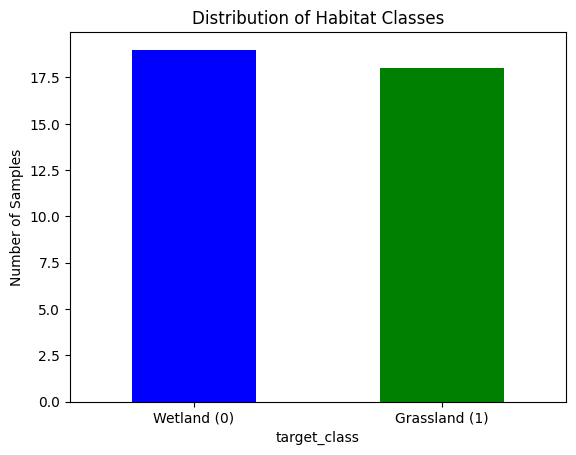

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your shapefile
gdf = gpd.read_file('/content/dataset/Pollardstown/Pollardstown_clappied.shp')

# 2. Apply your mapping to a new column
# This replicates exactly what the model "sees"
gdf['target_class'] = gdf['PRIMARY_FO'].map(HABITAT_MAP)

# 3. Drop rows that aren't in your mapping (NaNs)
filtered_gdf = gdf.dropna(subset=['target_class'])

# 4. Print the counts
print("--- Class Counts ---")
print(filtered_gdf['target_class'].value_counts())

# 5. Visualize
filtered_gdf['target_class'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.xticks([0, 1], ['Wetland (0)', 'Grassland (1)'], rotation=0)
plt.title('Distribution of Habitat Classes')
plt.ylabel('Number of Samples')
plt.show()

In [72]:
def build_small_vgg(input_shape=(224, 224, 4)):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),

        # Classification
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), # Crucial for small datasets
        layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_small_vgg()

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# --- 1. Settings ---
HABITAT_MAP = {
    'PF1': 0, 'WL2': 0, 'WN6': 0, 'WS1': 0, 'WS1/WL2': 0, 'WN6/FS1': 0, 'GS4/WS1': 0,
    'FS1': 1, 'FS1/FS2': 1, 'FS1/PF1': 1, 'GA1': 1, 'GS4': 1, 'GS4/FS1': 1, 'GS4/FS2': 1
}
# !!! CHANGE THIS to the actual column name in your shapefile !!!
HABITAT_COL = 'habitat_column'

# --- 2. Robust Data Generator ---
class HabitatGenerator(tf.keras.utils.PyDataset):
    def __init__(self, rgb_path, ndvi_path, gdf, batch_size=2, **kwargs):
        super().__init__(**kwargs)
        self.rgb_path = rgb_path
        self.ndvi_path = ndvi_path
        self.gdf = gdf
        self.batch_size = batch_size
        self.indices = np.arange(len(gdf))

    def __len__(self):
        return int(np.floor(len(self.gdf) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []

        with rasterio.open(self.rgb_path) as rgb_src, rasterio.open(self.ndvi_path) as ndvi_src:
            for i in batch_indices:
                row = self.gdf.iloc[i]
                try:
                    # Masking
                    rgb_crop, _ = mask(rgb_src, [row['geometry']], crop=True)
                    ndvi_crop, _ = mask(ndvi_src, [row['geometry']], crop=True)

                    # Merge to (4, H, W) -> (H, W, 4)
                    combined = np.moveaxis(np.concatenate([rgb_crop, ndvi_crop], axis=0), 0, -1)

                    # Resize to 224x224
                    final = np.zeros((224, 224, 4), dtype='float32')
                    h, w = min(224, combined.shape[0]), min(224, combined.shape[1])
                    if h < 2 or w < 2: continue
                    final[:h, :w, :] = combined[:h, :w, :]

                    # SCALE DATA: Ensure it is between 0 and 1
                    # Satellite data often has high values (e.g. 0-10000)
                    for c in range(4):
                        c_min, c_max = final[:,:,c].min(), final[:,:,c].max()
                        if c_max > c_min:
                            final[:,:,c] = (final[:,:,c] - c_min) / (c_max - c_min)

                    X.append(final)
                    y.append(HABITAT_MAP[row[HABITAT_COL]])
                except:
                    continue

        if len(X) == 0:
            return np.zeros((self.batch_size, 224, 224, 4)), np.zeros((self.batch_size,))

        return np.array(X, dtype='float32'), np.array(y, dtype='int32')

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- 3. Model with Heavy Augmentation & Batch Norm ---
def build_habitat_model():
    augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.3),
        layers.RandomContrast(0.2)
    ])

    inputs = layers.Input(shape=(224, 224, 4))
    x = augmentation(inputs)

    # Block 1
    x = layers.Conv2D(16, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Dense
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    # Using a slightly higher learning rate to "kickstart" the 0.693 loss
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- 4. Main Loop ---
gdf = gpd.read_file('your_habitats.shp') # <--- PATH TO SHP
gdf = gdf[gdf[HABITAT_COL].isin(HABITAT_MAP.keys())].copy()

# Shuffle and Split
gdf = gdf.sample(frac=1).reset_index(drop=True)
split = int(len(gdf) * 0.8)
train_gdf, val_gdf = gdf[:split], gdf[split:]

# Use batch_size=2 for more updates per epoch on small data
train_gen = HabitatGenerator('rgb.tif', 'ndvi.tif', train_gdf, batch_size=2)
val_gen = HabitatGenerator('rgb.tif', 'ndvi.tif', val_gdf, batch_size=2)

model = build_habitat_model()

# --- 5. THE DATA CHECK (Crucial) ---
# This will show you exactly what the model "sees"
X_check, y_check = train_gen[0]
print(f"Batch shape: {X_check.shape}, Max value: {X_check.max()}")
plt.imshow(X_check[0][:,:,:3])
plt.title(f"Target: {y_check[0]}")
plt.show()

# --- 6. Train ---
print("Training starting...")
model.fit(train_gen, validation_data=val_gen, epochs=50)